## Task 1 Image Classification

For the first part of this lab we are going to learn how to perform image classification. Using deep learning networks to perform image classification is a popular task and easy to get started with.A dataset comprised of paintings from Van Gogh and other artists will be used to create a binary classifier.
This dataset was discovered on [kaggle](https://www.kaggle.com/gfolego/vangogh) and built [1]. 


The dataset has already been downloaded. First let's explore the data and view some of the images in our dataset.


In [40]:
#import modules we plan to use
#-*- coding: utf-8 -*-
%matplotlib inline
import csv
from PIL import Image
import numpy as np
import tensorflow as tf
import skimage.io as io
import matplotlib.pyplot as plt
import scipy.ndimage


In [41]:
#Read a text file with a list of the training and validation images
TRAIN_LIST=[]
with open('/data/vgdb_2016/train.txt') as csvfile:
        train_list=csv.reader(csvfile)
        for row in train_list:
                TRAIN_LIST+=row
                
img_list=TRAIN_LIST[0::2]
label_list=TRAIN_LIST[1::2]

TEST_LIST=[]
with open('/data/vgdb_2016/test.txt') as csvfile:
        test_list=csv.reader(csvfile)
        for row in test_list:
                TEST_LIST+=row
                
test_img_list=TEST_LIST[0::2]
test_label_list=TEST_LIST[1::2]

index 106
Not Van Gogh Painting


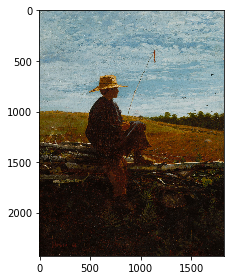

In [42]:
#View and image from our Dataset
from random import randint
SampleImageIndex=randint(0,len(img_list)) #select a random image from the training set
sample_image=io.imread(img_list[SampleImageIndex])
io.imshow(sample_image)
print("index "+str(SampleImageIndex))
if label_list[SampleImageIndex]== str(0):
    print("Not Van Gogh Painting")
else:
    print("Van Gogh Painting")



There is more than one way to ingest data into TensorFlow. Three approaches are described in the [documentation](https://www.tensorflow.org/programmers_guide/reading_data). For this part of the lab we are going to create a TensorFlow record of our data set. We are doing this because in some cases you may find that creating a binary is easier to use. A blog by [Daniil Pakhomov](http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/) was used to create this portion of the lab.

In [43]:
def _bytes_feature(value):
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
        return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

tfrecord_filename='/data/vgdb_2016/vg_classification.tfrecords'
test_tfrecord_filename='/data/vgdb_2016/test_classification.tfrecords'

In [ ]:

writer=tf.python_io.TFRecordWriter(tfrecord_filename)

original_images=[]

for img_path,object_class in zip(img_list,label_list):
  
        img2record=scipy.ndimage.imread(img_path)
        height,width,colorbands=img2record.shape
        original_images.append(img2record)
        img_raw = img2record.astype("uint8")

        img_raw=img_raw.tostring()
        example=tf.train.Example(features=tf.train.Features(feature={
                'height':_int64_feature(height),
                'width':_int64_feature(width),
                'depth':_int64_feature(colorbands),
                'label':_int64_feature(int(object_class)),
                'image_raw':_bytes_feature(img_raw)}))
        writer.write(example.SerializeToString())

writer.close()

print('finished creating tfrecord')

In this next step we are reading the TensorFlow record file and reconstructing the image to confirm that we have done it properly.

In [38]:
#Attempt to reconstruct image from tfrecordfile
reconstructed_images = []
out_classes=[]
record_iterator = tf.python_io.tf_record_iterator(path=tfrecord_filename)

for string_record in record_iterator:
    
    example = tf.train.Example()
    example.ParseFromString(string_record)
    
    height = int(example.features.feature['height']
                                 .int64_list
                                 .value[0])
    
    width = int(example.features.feature['width']
                                .int64_list
                                .value[0])
    depth = int(example.features.feature['depth']
                                .int64_list
                                .value[0])
    
    img_string = (example.features.feature['image_raw']
                                  .bytes_list
                                  .value[0])
    
    labels = (example.features.feature['label']
                                .int64_list
                                .value[0])
    
    img_1d = np.fromstring(img_string, dtype=np.uint8)
    reconstructed_img = img_1d.reshape((height, width, -1))
    
    reconstructed_images.append((reconstructed_img))
    out_classes.append((obj_class))

NameError: name 'obj_class' is not defined

In [ ]:
# Let's check if the first 5 reconstructed images match
#True == same 
NumOfImagesEval=5

for i in range(NumOfImagesEval): 
    print(sum(sum(sum(reconstructed_images[i]-original_images[i])))==0)

In [ ]:
reconstructed_images[0].shape
io.imshow(reconstructed_images[0])

In [ ]:
orig_image=io.imread(img_list[0])
io.imshow(orig_image)

Did it work? Were you able to view the reconstructed images?

Next we are going preprocess our data from the TensorFlow record file and create a batches for trarining. 

In [5]:

IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
BATCH_SIZE = 32
NUM_CLASSES=2
NUM_EXAMPLES_PER_EPOCH_FOR_TRAIN=264#len(img_list)
def read_and_decode(filename_queue):
    
    reader = tf.TFRecordReader()

    _, serialized_example = reader.read(filename_queue)

    features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
        'height': tf.FixedLenFeature([], tf.int64),
        'width': tf.FixedLenFeature([], tf.int64),
        'depth': tf.FixedLenFeature([], tf.int64), 
        'label':tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string)
        })

    # Convert from a scalar string tensor to a uint8 tensor 
    
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)
    label = tf.cast(features['label'], tf.int32)
    image_shape = tf.stack([height, width, 3])
    #image.set_shape(image_shape)
    
    image = tf.reshape(image, image_shape)
        
    #image_size_const = tf.constant((IMAGE_HEIGHT, IMAGE_WIDTH, 3), dtype=tf.int32)
        
    #Randomly cropping image
    random_crop_image=tf.random_crop(image, size=[IMAGE_HEIGHT,IMAGE_WIDTH,3], seed=None, name=None)

    min_after_dequeue = 500
    capacity = min_after_dequeue + 3 * BATCH_SIZE 
    shuffled_img, shuffled_label = tf.train.shuffle_batch([random_crop_image, label],
                                                 batch_size=BATCH_SIZE ,
                                                 capacity=capacity,
                                                 num_threads=4,
                                                 min_after_dequeue=min_after_dequeue)
    
    return shuffled_img, shuffled_label

Now we are going to create our CNN model. For this example we are applying the CIFAR10 network. This network is comprised of two convolutional, pooling, normalization, ReLU activation, and fully connected layers. There is more than one place to view examples of this CNN, including the [TensorFlow documenation](https://www.tensorflow.org/tutorials/deep_cnn) as well as [Caffe](http://caffe.berkeleyvision.org/gathered/examples/cifar10.html).

In [6]:
def cnn_model(img):
    #CIFAR10 Network
    #img=tf.to_float(showimage)
    conv1 = tf.nn.conv2d(img, variables_dict['conv1_weights'], [1, 1, 1, 1], padding='SAME')
    act_conv1=tf.nn.relu(tf.nn.bias_add(conv1,variables_dict['conv1_biases']))
             
    ####################### Pooling Layer ##################
    pool1=tf.nn.max_pool(act_conv1,ksize=[1,3,3,1],strides=[1,2,2,1],padding='SAME')
    norm1 = tf.nn.lrn(pool1, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75)
    ###################### Conv Layer 2 ####################

    conv2=tf.nn.conv2d(norm1, variables_dict['conv2_weights'], [1, 1, 1, 1], padding='SAME')
    act_conv2=tf.nn.relu(tf.nn.bias_add(conv2,variables_dict['conv2_biases']))
                        
    norm2 = tf.nn.lrn(conv2, 4, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name='norm2')
              
    ########################## Pooling Layer ######################
                
    pool2 = tf.nn.max_pool(norm2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='SAME', name='pool2')
                
    ######################### Reshape ############################
    reshape = tf.reshape(pool2, [BATCH_SIZE, -1])
    dim = reshape.get_shape()[1].value #dim==pool2[0]*pool[1]*#featuremaps==4096
    linear1 = tf.nn.relu(tf.matmul(reshape, variables_dict['linear1_weights']) + variables_dict['linear1_biases'], 
                                 name="linear1")
    linear2 = tf.nn.relu(tf.matmul(linear1, variables_dict['linear2_weights']) + variables_dict['linear2_biases'],
                                name="linear2")
    softmax_linear = tf.add(tf.matmul(linear2, variables_dict['linear3_weights']),variables_dict['linear3_biases'],
                                name="softmax_output")
    return softmax_linear

When training varialbles are used to hold and update network parameters. The variable_dict is a dictionary of all the variables for the CIFAR CNN, cnn_model.

In [7]:
tf.reset_default_graph()

variables_dict = {
    "conv1_weights":tf.Variable(tf.truncated_normal([5, 5, 3, 64],stddev=1.0),name="conv1_weights"),
    "conv1_biases": tf.Variable(tf.constant(0.1, shape=[64]), name="conv1_biases"),
    "conv2_weights":tf.Variable(tf.random_normal([5, 5, 64, 64],stddev=1.0),name="conv2_weights"),
    "conv2_biases": tf.Variable(tf.constant(0.1,shape=[64]), name="conv2_biases"),
    "linear1_weights":tf.Variable(tf.truncated_normal([4096,384],stddev=1.0),name="linear1_weights"),
    "linear1_biases": tf.Variable(tf.constant(0.1,shape=[384]), name="linear1_biases"),
    "linear2_weights":tf.Variable(tf.truncated_normal([384,192],stddev=1.0),name="linear2_weights"),
    "linear2_biases": tf.Variable(tf.constant(0.1,shape=[192]), name="linear2_biases"),
    "linear3_weights":tf.Variable(tf.truncated_normal([192,NUM_CLASSES],stddev=1.0),name="linear2_weights"),
    "linear3_biases": tf.Variable(tf.constant(0.1,shape=[NUM_CLASSES]), name="linear2_biases"),
}


filename_queue = tf.train.string_input_producer([tfrecord_filename], num_epochs=200)
val_filename_queue = tf.train.string_input_producer([test_tfrecord_filename], num_epochs=200)

# tf placeholders
img = tf.placeholder(tf.float32,[BATCH_SIZE,IMAGE_HEIGHT,IMAGE_WIDTH,3])
y_=tf.placeholder(tf.int32,[BATCH_SIZE])

images, labels = read_and_decode(filename_queue)
val_images, val_labels=read_and_decode(val_filename_queue)

Now are are ready to start training. Can you recall all of the work we did to prepare our data and configure our network?

In [8]:
tf.get_variable_scope().reuse_variables()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

########################## Calculate Loss and Accuracy ####################
softmax_linear=cnn_model(tf.to_float(img))
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_, 
        logits=softmax_linear, name='cross_entropy_per_example')
#Loss
cross_entropy_mean = tf.reduce_mean(cross_entropy, name='cross_entropy')

train_step = tf.train.GradientDescentOptimizer(learning_rate=0.00001).minimize(cross_entropy) #weight updater
correct_prediction=tf.equal(tf.cast(tf.argmax(softmax_linear,1),tf.int32),y_)
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
#images, labels = read_and_decode(filename_queue)  

#Add ops to save and restore all the variables
saver = tf.train.Saver()

with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for i in xrange(1000):
                image,label=sess.run([images,labels])
                #print(label)
                _,loss=sess.run([train_step,cross_entropy_mean], 
                                  feed_dict={img:image, y_:label})
                
                if i % 50 == 0:
                    val_image,val_label=sess.run([val_images,val_labels])
                    acc2=sess.run([accuracy], 
                        feed_dict={img:val_image, y_:val_label})
                    print("iteration ",i, "loss ", loss, 'val accuracy', acc2)
           
        # Save the variables to disk.
        save_path = saver.save(sess, "my_first_cnn.ckpt")
        print("Model saved in file: %s" % save_path)                                    
        coord.request_stop()
        coord.join(threads)
        sess.close()
        


('iteration ', 0, 'loss ', 65120.965, 'val accuracy', [0.65625])
('iteration ', 50, 'loss ', 2.5889506, 'val accuracy', [0.6875])
('iteration ', 100, 'loss ', 0.73203075, 'val accuracy', [0.75])
('iteration ', 150, 'loss ', 0.6770401, 'val accuracy', [0.65625])
('iteration ', 200, 'loss ', 0.73524368, 'val accuracy', [0.46875])
('iteration ', 250, 'loss ', 0.68744767, 'val accuracy', [0.375])
('iteration ', 300, 'loss ', 0.71427113, 'val accuracy', [0.65625])
('iteration ', 350, 'loss ', 0.68066496, 'val accuracy', [0.71875])
('iteration ', 400, 'loss ', 0.68059063, 'val accuracy', [0.65625])
('iteration ', 450, 'loss ', 0.68057084, 'val accuracy', [0.625])
('iteration ', 500, 'loss ', 0.67538893, 'val accuracy', [0.625])
('iteration ', 550, 'loss ', 0.62283337, 'val accuracy', [0.625])
('iteration ', 600, 'loss ', 0.66357464, 'val accuracy', [0.71875])
('iteration ', 650, 'loss ', 0.62236953, 'val accuracy', [0.53125])
('iteration ', 700, 'loss ', 0.61074364, 'val accuracy', [0.625])


In [ ]:
#Let's take a look at some of the data from the batch. 

item=5
plt.imshow(image[item, :, :, :])
if label[item]==1:
    print("This is part of a Vanh Gogh painting")
else:
    print("This is not part of a Vanh Gogh painting")



There are many things we could do to improve this accuracy. Can you name three?


### References 
[1] From Impressionism to Expressionism: Automatically Identifying Van Gogh's Paintings", which has been published on the 23rd IEEE International Conference on Image Processing (ICIP 2016) 

[2] Pakhomov, Daniil. TFrecords Guide. December 21, 2016. http://warmspringwinds.github.io/tensorflow/tf-slim/2016/12/21/tfrecords-guide/

[3] Aymeric Damien. TensorFlow Examples, Neural Networks, ConvolutionalNetwork. https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/convolutional_network.ipynb

[4] TensorFlow Tutorial - Convolutional Neural Networks.